# Phase 5: Latent Diffusion with VAE

In previous phases, we performed flow matching directly in **pixel space**. While this works well for small images (MNIST 28×28, CIFAR-10 32×32), it doesn't scale to high-resolution images.

## The Scaling Problem

Consider the computational cost of pixel-space diffusion:

| Resolution | Dimensions | Relative Cost |
|------------|------------|---------------|
| 32×32×3 | 3,072 | 1× |
| 64×64×3 | 12,288 | 4× |
| 256×256×3 | 196,608 | 64× |
| 512×512×3 | 786,432 | 256× |

Transformer self-attention has O(N²) complexity in sequence length. For images:
- 32×32 with 4×4 patches = 64 tokens → 4,096 attention pairs
- 256×256 with 4×4 patches = 4,096 tokens → 16,777,216 attention pairs

This is **4,096× more computation** just for attention!

## The Solution: Latent Diffusion

The key insight of **Stable Diffusion** (Rombach et al., 2022):

> Instead of diffusing in pixel space, first compress images to a smaller latent space, then do diffusion there.

```
Pixel Space Diffusion:
  noise (256×256×3) ──flow matching──> image (256×256×3)
  
Latent Space Diffusion:
  noise (32×32×4) ──flow matching──> latent (32×32×4) ──VAE decode──> image (256×256×3)
```

With 8× spatial compression:
- 256×256×3 image → 32×32×4 latent
- 196,608 → 4,096 dimensions (48× smaller!)

## What You'll Learn

1. **Variational Autoencoders (VAEs)**: How to compress images to latent space
2. **The Reparameterization Trick**: How to backpropagate through sampling
3. **Latent Flow Matching**: Training diffusion in compressed space
4. **The Full Pipeline**: Encode → Denoise → Decode

## Mathematical Framework

### VAE: Learning a Latent Space

A VAE learns two functions:

**Encoder**: $q_\phi(z|x) = \mathcal{N}(\mu_\phi(x), \sigma^2_\phi(x))$
- Maps image $x$ to a distribution over latents $z$
- Outputs mean $\mu$ and variance $\sigma^2$ of a Gaussian

**Decoder**: $p_\theta(x|z)$
- Maps latent $z$ back to image $x$
- Learns to reconstruct the original image

### Training Objective (ELBO)

The VAE is trained to maximize the Evidence Lower Bound:

$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z))$$

In practice, we minimize:

$$\mathcal{L}_{VAE} = \underbrace{\|x - \text{decode}(\text{encode}(x))\|^2}_{\text{reconstruction}} + \beta \cdot \underbrace{D_{KL}(q(z|x) \| \mathcal{N}(0,I))}_{\text{regularization}}$$

### Latent Diffusion

Once the VAE is trained, we do flow matching in latent space:

1. **Encode training data**: $z_0 = \text{encode}(x)$
2. **Flow matching on latents**: Learn $v_\theta(z_t, t)$ where $z_t = (1-t)z_0 + tz_1$
3. **Generate**: Sample $z_1 \sim \mathcal{N}(0,I)$, integrate to $z_0$, decode to $x = \text{decode}(z_0)$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
from text_to_image import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## 1. Variational Autoencoders: The Compression Engine

### Why VAE Instead of Regular Autoencoder?

A regular autoencoder learns a deterministic mapping:
$$x \xrightarrow{\text{encode}} z \xrightarrow{\text{decode}} \hat{x}$$

The problem: the latent space may have "holes" - regions where no training data maps to, producing garbage when decoded.

A VAE learns a **probabilistic** mapping:
$$x \xrightarrow{\text{encode}} (\mu, \sigma^2) \xrightarrow{\text{sample}} z \xrightarrow{\text{decode}} \hat{x}$$

The KL regularization term encourages the latent distribution to be close to $\mathcal{N}(0, I)$, ensuring:
1. **Smooth latent space**: Nearby points decode to similar images
2. **No holes**: The entire space is "covered" by the prior
3. **Sampling works**: We can sample $z \sim \mathcal{N}(0, I)$ and decode to valid images

### The Reparameterization Trick

The encoder outputs $\mu$ and $\log\sigma^2$ (log-variance for numerical stability).

To sample $z \sim \mathcal{N}(\mu, \sigma^2)$ while allowing backpropagation:

$$z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

This moves the randomness ($\epsilon$) outside the computational graph, making $z$ differentiable with respect to $\mu$ and $\sigma$.

### Architecture Overview

```
Image (32×32×3)                                    Image (32×32×3)
      |                                                  ^
      v                                                  |
+------------+                                    +------------+
|  Encoder   |  (downsample 4×)                   |  Decoder   |  (upsample 4×)
+------------+                                    +------------+
      |                                                  ^
      v                                                  |
  (μ, log σ²)  ───> sample z = μ + σε ───────────>    z
   (8×8×8)              (8×8×4)                     (8×8×4)
```

Note: The encoder outputs 2× the latent channels (for $\mu$ and $\log\sigma^2$), then we sample to get the final latent.

In [2]:
# Load CIFAR-10 for this demonstration
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

print(f"Dataset size: {len(train_dataset):,} images")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Pixel range: [{train_dataset[0][0].min():.1f}, {train_dataset[0][0].max():.1f}]")

Dataset size: 50,000 images
Image shape: torch.Size([3, 32, 32])
Pixel range: [-1.0, 1.0]


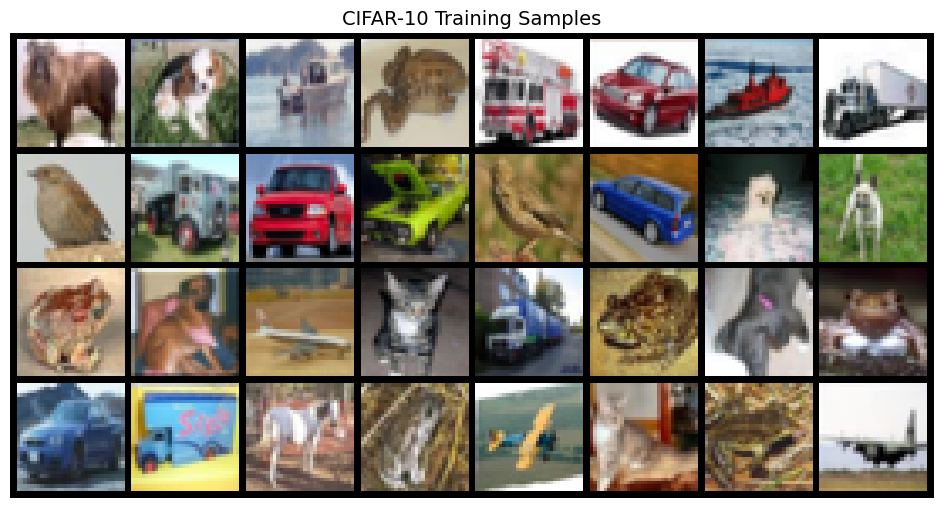

In [3]:
# Visualize some training samples
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Get a batch and visualize
sample_batch, sample_labels = next(iter(train_loader))
show_images(sample_batch[:32], title="CIFAR-10 Training Samples")

## 2. Building the VAE

Our VAE architecture:

**Encoder** (32×32 → 8×8, 4× spatial compression):
- Input conv: 3 → 64 channels
- Downsample block 1: 64 → 64, stride 2 (32→16)
- Downsample block 2: 64 → 128, stride 2 (16→8)
- Output conv: 128 → 8 (4 for μ, 4 for log σ²)

**Decoder** (8×8 → 32×32):
- Input conv: 4 → 128 channels
- Upsample block 1: 128 → 64, upsample 2× (8→16)
- Upsample block 2: 64 → 64, upsample 2× (16→32)
- Output conv: 64 → 3

**Compression Ratio**:
- Pixel space: 32×32×3 = 3,072 values
- Latent space: 8×8×4 = 256 values
- **12× compression**

In [4]:
from text_to_image.vae import SmallVAE

# Create VAE for CIFAR-10 (32×32 RGB)
vae = SmallVAE(
    in_channels=3,        # RGB
    latent_channels=4,    # 4 latent channels
    hidden_channels=64,   # Base hidden channels
).to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"VAE parameters: {num_params:,}")

# Test forward pass
test_img = torch.randn(4, 3, 32, 32, device=device)
with torch.no_grad():
    recon, mean, logvar = vae(test_img)
    latent = vae.encode(test_img)

print(f"\nShape analysis:")
print(f"  Input image:  {test_img.shape}  ({test_img.numel() // 4:,} values per image)")
print(f"  Latent mean:  {mean.shape}  ({mean.numel() // 4:,} values per image)")
print(f"  Latent z:     {latent.shape}")
print(f"  Recon image:  {recon.shape}")
print(f"\nCompression ratio: {test_img.numel() / latent.numel():.1f}×")

VAE parameters: 942,539

Shape analysis:
  Input image:  torch.Size([4, 3, 32, 32])  (3,072 values per image)
  Latent mean:  torch.Size([4, 4, 8, 8])  (256 values per image)
  Latent z:     torch.Size([4, 4, 8, 8])
  Recon image:  torch.Size([4, 3, 32, 32])

Compression ratio: 12.0×


## 3. The VAE Loss Function

### Reconstruction Loss

Simple MSE between input and reconstruction:

$$\mathcal{L}_{recon} = \|x - \hat{x}\|^2 = \|x - \text{decode}(\text{encode}(x))\|^2$$

### KL Divergence Loss

The KL divergence between the encoder distribution and the prior:

$$D_{KL}(q(z|x) \| p(z)) = D_{KL}(\mathcal{N}(\mu, \sigma^2) \| \mathcal{N}(0, I))$$

For Gaussians, this has a closed form:

$$D_{KL} = -\frac{1}{2} \sum_{i=1}^{d} \left(1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2\right)$$

**Intuition**:
- If $\mu \to 0$ and $\sigma \to 1$: KL → 0 (matches prior)
- If $\mu$ is large: KL increases (penalizes mean far from 0)
- If $\sigma$ is very small or large: KL increases (penalizes variance different from 1)

### Combining the Losses

$$\mathcal{L}_{VAE} = \mathcal{L}_{recon} + \beta \cdot D_{KL}$$

For **latent diffusion**, we use very small $\beta$ (e.g., 0.00001) because:
1. We prioritize reconstruction quality (the decoder needs to produce sharp images)
2. The diffusion model will handle generation (so we don't need perfect sampling from the prior)
3. We just need good encoding/decoding

In [5]:
# Visualize KL divergence behavior
def kl_divergence(mu, logvar):
    """KL divergence from N(mu, sigma^2) to N(0, 1)."""
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Test different scenarios
scenarios = [
    ("μ=0, σ=1 (perfect match)", 0.0, 0.0),
    ("μ=1, σ=1 (shifted mean)", 1.0, 0.0),
    ("μ=0, σ=0.5 (narrow)", 0.0, np.log(0.25)),
    ("μ=0, σ=2 (wide)", 0.0, np.log(4.0)),
    ("μ=2, σ=0.5 (shifted+narrow)", 2.0, np.log(0.25)),
]

print("KL Divergence Examples (per dimension):")
print("-" * 50)
for name, mu_val, logvar_val in scenarios:
    mu = torch.tensor([mu_val])
    logvar = torch.tensor([logvar_val])
    kl = kl_divergence(mu, logvar).item()
    print(f"{name:35s}: KL = {kl:.4f}")

print("\nThe KL term encourages μ→0 and σ→1 (standard normal).")

KL Divergence Examples (per dimension):
--------------------------------------------------
μ=0, σ=1 (perfect match)           : KL = -0.0000
μ=1, σ=1 (shifted mean)            : KL = 0.5000
μ=0, σ=0.5 (narrow)                : KL = 0.3181
μ=0, σ=2 (wide)                    : KL = 0.8069
μ=2, σ=0.5 (shifted+narrow)        : KL = 2.3181

The KL term encourages μ→0 and σ→1 (standard normal).


## 4. Training the VAE

### Training Algorithm

For each batch:
1. Forward pass: $x \to (\mu, \log\sigma^2) \to z \to \hat{x}$
2. Compute reconstruction loss: $\mathcal{L}_{recon} = \|x - \hat{x}\|^2$
3. Compute KL loss: $\mathcal{L}_{KL} = D_{KL}(q(z|x) \| p(z))$
4. Total loss: $\mathcal{L} = \mathcal{L}_{recon} + \beta \cdot \mathcal{L}_{KL}$
5. Backpropagate and update

### $\beta$ Schedule

For latent diffusion, we use $\beta \approx 10^{-5}$. This extremely small value means:
- Reconstruction quality is prioritized
- Latents may not perfectly follow $\mathcal{N}(0,I)$
- But that's OK - we'll compute a scale factor to normalize them

In [6]:
from text_to_image.train import VAETrainer

# Create trainer
vae_trainer = VAETrainer(
    model=vae,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    kl_weight=0.00001,  # Very small β for latent diffusion
    device=device,
)

# Train VAE
VAE_EPOCHS = 30  # Increase for better reconstruction
print(f"Training VAE for {VAE_EPOCHS} epochs...")
print(f"KL weight (β): {vae_trainer.kl_weight}")
print()

vae_losses = vae_trainer.train(num_epochs=VAE_EPOCHS)

Training VAE for 30 epochs...
KL weight (β): 1e-05

Training VAE on cuda
Model parameters: 942,539
KL weight (β): 1e-05


Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:11<00:00, 32.62it/s, loss=0.0312, recon=0.0263]


Epoch 1: loss=0.0547, recon=0.0504, kl=430.8264


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.73it/s, loss=0.0264, recon=0.0214]


Epoch 2: loss=0.0279, recon=0.0230, kl=495.5611


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.73it/s, loss=0.0215, recon=0.0165]


Epoch 3: loss=0.0238, recon=0.0188, kl=501.9341


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.82it/s, loss=0.0207, recon=0.0156]


Epoch 4: loss=0.0211, recon=0.0161, kl=504.8594


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.64it/s, loss=0.0199, recon=0.0149]


Epoch 5: loss=0.0199, recon=0.0149, kl=501.4922


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.61it/s, loss=0.0200, recon=0.0151]


Epoch 6: loss=0.0192, recon=0.0142, kl=497.6676


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.74it/s, loss=0.0189, recon=0.0139]


Epoch 7: loss=0.0186, recon=0.0137, kl=493.7772


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.71it/s, loss=0.0183, recon=0.0135]


Epoch 8: loss=0.0181, recon=0.0132, kl=489.9455


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.73it/s, loss=0.0181, recon=0.0132]


Epoch 9: loss=0.0178, recon=0.0129, kl=486.5490


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.77it/s, loss=0.0165, recon=0.0117]


Epoch 10: loss=0.0175, recon=0.0127, kl=483.6637


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.73it/s, loss=0.0169, recon=0.0122]


Epoch 11: loss=0.0173, recon=0.0125, kl=481.1393


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.75it/s, loss=0.0173, recon=0.0125]


Epoch 12: loss=0.0171, recon=0.0123, kl=478.7877


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.65it/s, loss=0.0174, recon=0.0126]


Epoch 13: loss=0.0169, recon=0.0121, kl=476.9802


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.62it/s, loss=0.0157, recon=0.0110]


Epoch 14: loss=0.0167, recon=0.0120, kl=475.3418


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.68it/s, loss=0.0159, recon=0.0112]


Epoch 15: loss=0.0166, recon=0.0118, kl=473.9422


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.71it/s, loss=0.0162, recon=0.0115]


Epoch 16: loss=0.0165, recon=0.0117, kl=472.6606


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.74it/s, loss=0.0160, recon=0.0113]


Epoch 17: loss=0.0163, recon=0.0116, kl=471.4132


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.71it/s, loss=0.0159, recon=0.0113]


Epoch 18: loss=0.0162, recon=0.0115, kl=470.5784


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.72it/s, loss=0.0158, recon=0.0111]


Epoch 19: loss=0.0161, recon=0.0114, kl=469.9021


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.71it/s, loss=0.0156, recon=0.0109]


Epoch 20: loss=0.0160, recon=0.0113, kl=469.1629


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.74it/s, loss=0.0161, recon=0.0114]


Epoch 21: loss=0.0160, recon=0.0113, kl=468.3142


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.60it/s, loss=0.0173, recon=0.0125]


Epoch 22: loss=0.0159, recon=0.0112, kl=467.8830


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.36it/s, loss=0.0157, recon=0.0111]


Epoch 23: loss=0.0158, recon=0.0111, kl=467.3903


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.40it/s, loss=0.0150, recon=0.0103]


Epoch 24: loss=0.0157, recon=0.0111, kl=466.8100


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.54it/s, loss=0.0151, recon=0.0105]


Epoch 25: loss=0.0157, recon=0.0110, kl=466.3322


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.48it/s, loss=0.0155, recon=0.0108]


Epoch 26: loss=0.0156, recon=0.0109, kl=465.9661


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.48it/s, loss=0.0156, recon=0.0109]


Epoch 27: loss=0.0155, recon=0.0109, kl=465.5599


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.44it/s, loss=0.0155, recon=0.0108]


Epoch 28: loss=0.0155, recon=0.0108, kl=465.1631


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.38it/s, loss=0.0149, recon=0.0102]


Epoch 29: loss=0.0154, recon=0.0108, kl=464.8582


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:06<00:00, 61.59it/s, loss=0.0153, recon=0.0107]


Epoch 30: loss=0.0154, recon=0.0107, kl=464.4968

Computing latent scale factor...
Scale factor: 0.9622


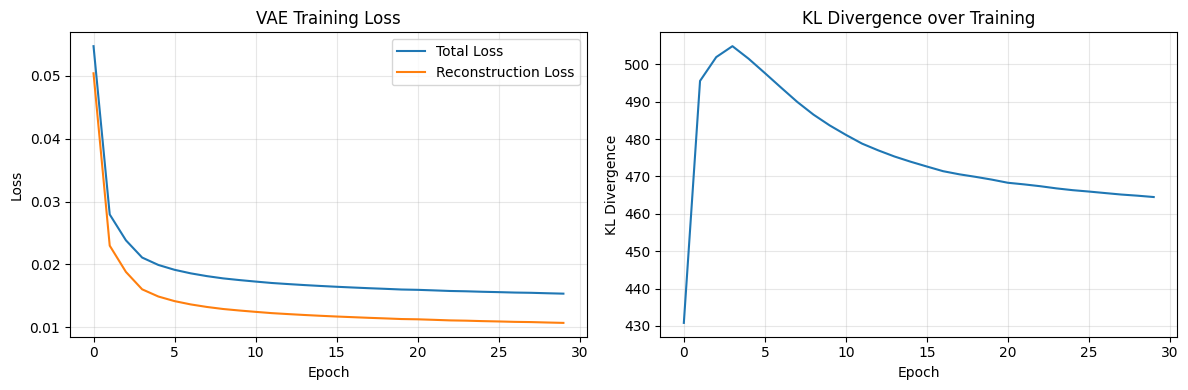

Final reconstruction loss: 0.0107
Final KL divergence: 464.4968


In [7]:
# Plot VAE training loss
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(vae_trainer.losses, label='Total Loss')
axes[0].plot(vae_trainer.recon_losses, label='Reconstruction Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('VAE Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(vae_trainer.kl_losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('KL Divergence over Training')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final reconstruction loss: {vae_trainer.recon_losses[-1]:.4f}")
print(f"Final KL divergence: {vae_trainer.kl_losses[-1]:.4f}")

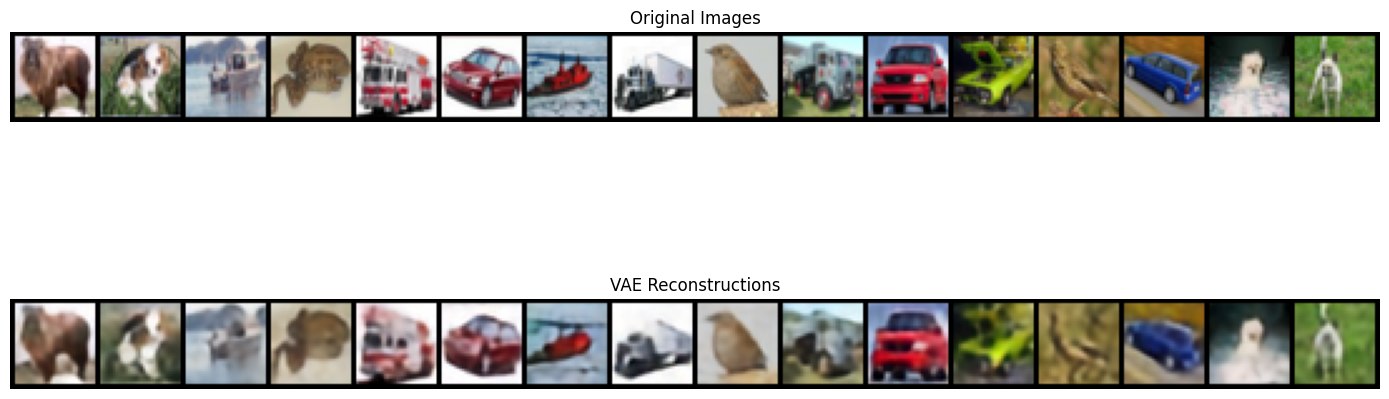


Reconstruction MSE: 0.0129
The VAE successfully compresses and reconstructs images!


In [8]:
# Visualize VAE reconstructions
vae.eval()

test_batch = sample_batch[:16].to(device)

with torch.no_grad():
    recon, _, _ = vae(test_batch)

# Show original vs reconstruction
fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Original images
original_grid = torchvision.utils.make_grid((test_batch + 1) / 2, nrow=16, padding=2)
axes[0].imshow(original_grid.permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Original Images', fontsize=12)
axes[0].axis('off')

# Reconstructed images
recon_grid = torchvision.utils.make_grid((recon + 1) / 2, nrow=16, padding=2)
axes[1].imshow(recon_grid.permute(1, 2, 0).cpu().clamp(0, 1).numpy())
axes[1].set_title('VAE Reconstructions', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Compute reconstruction error
mse = F.mse_loss(recon, test_batch).item()
print(f"\nReconstruction MSE: {mse:.4f}")
print("The VAE successfully compresses and reconstructs images!")

## 5. Exploring the Latent Space

Let's visualize what the latent space looks like.

### Latent Statistics

After training, we compute a **scale factor** to normalize the latent space:

$$z_{normalized} = z / \sigma_{data}$$

where $\sigma_{data}$ is the empirical standard deviation of encoded latents.

This ensures the latent space has approximately unit variance, matching the noise distribution $\mathcal{N}(0, I)$ we'll use for flow matching.

In [9]:
# Analyze latent space statistics
vae.eval()

all_means = []
all_stds = []

with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        if i >= 50:  # Use 50 batches for stats
            break
        images = images.to(device)
        z = vae.encode(images, sample=False)  # Use mean encoding
        all_means.append(z.mean().item())
        all_stds.append(z.std().item())

avg_mean = np.mean(all_means)
avg_std = np.mean(all_stds)

print(f"Latent Space Statistics:")
print(f"  Mean: {avg_mean:.4f} (ideally ≈ 0)")
print(f"  Std:  {avg_std:.4f} (will be normalized to ≈ 1)")
print(f"\nVAE scale factor: {vae.scale_factor.item():.4f}")

Latent Space Statistics:
  Mean: 0.0143 (ideally ≈ 0)
  Std:  0.9981 (will be normalized to ≈ 1)

VAE scale factor: 0.9622


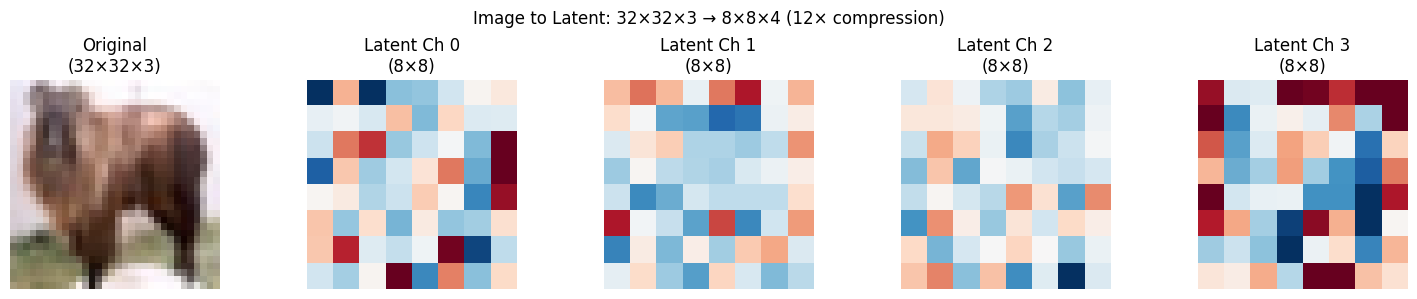


Latent shape: torch.Size([1, 4, 8, 8])
Latent values: min=-3.49, max=2.73


In [10]:
# Visualize latent channels
test_img = sample_batch[0:1].to(device)

with torch.no_grad():
    z = vae.encode(test_img, sample=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original image
axes[0].imshow((test_img[0].cpu().permute(1, 2, 0) + 1) / 2)
axes[0].set_title('Original\n(32×32×3)')
axes[0].axis('off')

# Each latent channel
for i in range(4):
    latent_ch = z[0, i].cpu().numpy()
    axes[i+1].imshow(latent_ch, cmap='RdBu', vmin=-2, vmax=2)
    axes[i+1].set_title(f'Latent Ch {i}\n(8×8)')
    axes[i+1].axis('off')

plt.suptitle('Image to Latent: 32×32×3 → 8×8×4 (12× compression)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nLatent shape: {z.shape}")
print(f"Latent values: min={z.min():.2f}, max={z.max():.2f}")

## 6. Flow Matching in Latent Space

Now we train a DiT to perform flow matching **in the latent space** instead of pixel space.

### The Key Insight

Everything is the same as pixel-space flow matching, but we work with latents:

| Pixel Space | Latent Space |
|-------------|---------------|
| $x_0$ = image | $z_0$ = encode(image) |
| $x_1 \sim \mathcal{N}(0, I)$ | $z_1 \sim \mathcal{N}(0, I)$ |
| $x_t = (1-t)x_0 + tx_1$ | $z_t = (1-t)z_0 + tz_1$ |
| $v = x_1 - x_0$ | $v = z_1 - z_0$ |
| Generate $x$ directly | Generate $z$, then decode |

### DiT Architecture for Latent Space

The DiT operates on the latent shape (8×8×4 for our VAE):
- `in_channels=4` (latent channels)
- `img_size=8` (latent spatial size)
- `patch_size=2` (4×4 = 16 patches)

This is **much smaller** than pixel-space DiT!

In [11]:
from text_to_image.dit import DiT

# Create DiT for latent space
# Latent shape: (4, 8, 8)
latent_dit = DiT(
    img_size=8,           # Latent spatial size
    patch_size=2,         # 2×2 patches → 4×4 = 16 tokens
    in_channels=4,        # Latent channels
    embed_dim=256,        # Transformer embedding dimension
    depth=6,              # Number of transformer blocks
    num_heads=8,          # Attention heads
    mlp_ratio=4.0,
).to(device)

latent_dit_params = sum(p.numel() for p in latent_dit.parameters())

# Compare with pixel-space DiT
pixel_dit = DiT(
    img_size=32,
    patch_size=4,
    in_channels=3,
    embed_dim=256,
    depth=6,
    num_heads=8,
)
pixel_dit_params = sum(p.numel() for p in pixel_dit.parameters())

print("Model Comparison:")
print(f"  Pixel-space DiT: {pixel_dit_params:,} params, {8*8}=64 tokens")
print(f"  Latent-space DiT: {latent_dit_params:,} params, {4*4}=16 tokens")
print(f"\nToken reduction: {64/16:.0f}×")
print(f"Attention cost reduction: {(64*64)/(16*16):.0f}×")

Model Comparison:
  Pixel-space DiT: 12,368,176 params, 64=64 tokens
  Latent-space DiT: 12,351,760 params, 16=16 tokens

Token reduction: 4×
Attention cost reduction: 16×


In [12]:
from text_to_image.train import LatentDiffusionTrainer

# Create latent diffusion trainer
latent_trainer = LatentDiffusionTrainer(
    model=latent_dit,
    vae=vae,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

# Train
LATENT_EPOCHS = 30  # Increase for better results
print(f"Training Latent Diffusion for {LATENT_EPOCHS} epochs...")
print(f"VAE is frozen - only DiT is trained.")
print()

latent_losses = latent_trainer.train(num_epochs=LATENT_EPOCHS)

Training Latent Diffusion for 30 epochs...
VAE is frozen - only DiT is trained.

Training Latent Diffusion on cuda
DiT parameters: 12,351,760
VAE parameters: 0 (frozen)


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 37.84it/s, loss=1.4914]


Epoch 1: avg_loss = 1.6260


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.32it/s, loss=1.4689]


Epoch 2: avg_loss = 1.4559


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.85it/s, loss=1.4168]


Epoch 3: avg_loss = 1.4381


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.26it/s, loss=1.4446]


Epoch 4: avg_loss = 1.4247


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.20it/s, loss=1.4204]


Epoch 5: avg_loss = 1.4184


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.02it/s, loss=1.4169]


Epoch 6: avg_loss = 1.4127


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.16it/s, loss=1.4330]


Epoch 7: avg_loss = 1.4072


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.02it/s, loss=1.3934]


Epoch 8: avg_loss = 1.4037


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.05it/s, loss=1.3652]


Epoch 9: avg_loss = 1.3986


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.94it/s, loss=1.3804]


Epoch 10: avg_loss = 1.3959


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.21it/s, loss=1.4048]


Epoch 11: avg_loss = 1.3937


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.3395]


Epoch 12: avg_loss = 1.3875


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.25it/s, loss=1.3965]


Epoch 13: avg_loss = 1.3867


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.65it/s, loss=1.3841]


Epoch 14: avg_loss = 1.3802


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.88it/s, loss=1.4003]


Epoch 15: avg_loss = 1.3799


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.01it/s, loss=1.3576]


Epoch 16: avg_loss = 1.3765


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.17it/s, loss=1.3686]


Epoch 17: avg_loss = 1.3735


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.28it/s, loss=1.3856]


Epoch 18: avg_loss = 1.3698


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.33it/s, loss=1.3958]


Epoch 19: avg_loss = 1.3698


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.15it/s, loss=1.3497]


Epoch 20: avg_loss = 1.3669


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.22it/s, loss=1.3163]


Epoch 21: avg_loss = 1.3668


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.97it/s, loss=1.3715]


Epoch 22: avg_loss = 1.3638


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.16it/s, loss=1.3681]


Epoch 23: avg_loss = 1.3643


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.25it/s, loss=1.3598]


Epoch 24: avg_loss = 1.3613


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.02it/s, loss=1.4201]


Epoch 25: avg_loss = 1.3612


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.24it/s, loss=1.3454]


Epoch 26: avg_loss = 1.3579


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.09it/s, loss=1.3907]


Epoch 27: avg_loss = 1.3589


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.24it/s, loss=1.3454]


Epoch 28: avg_loss = 1.3573


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.29it/s, loss=1.3719]


Epoch 29: avg_loss = 1.3549


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:09<00:00, 39.23it/s, loss=1.3407]

Epoch 30: avg_loss = 1.3542


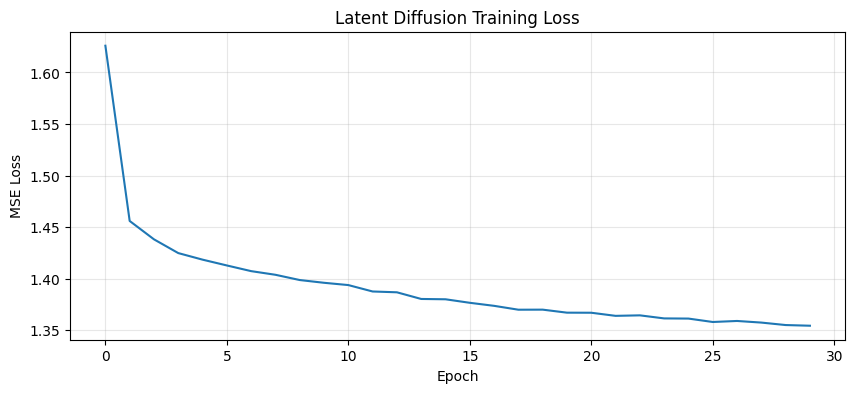

Final loss: 1.3542


In [13]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(latent_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Latent Diffusion Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {latent_losses[-1]:.4f}")

## 7. Sampling from Latent Space

Generation in latent diffusion:

1. **Sample noise in latent space**: $z_1 \sim \mathcal{N}(0, I)$, shape (4, 8, 8)
2. **Integrate ODE in latent space**: $z_1 \to z_0$ using learned velocity
3. **Decode to pixels**: $x = \text{decode}(z_0)$, shape (3, 32, 32)

### Why This Is Efficient

All the expensive ODE integration happens in the small latent space:
- 50 steps × 16 tokens = 800 attention operations per image
- vs. 50 steps × 64 tokens = 3,200 operations in pixel space

The VAE decode is just one forward pass at the end.

Generating samples via latent diffusion...
  1. Sample noise in latent space (4×8×8)
  2. Integrate ODE from t=1 to t=0
  3. Decode to pixel space (3×32×32)



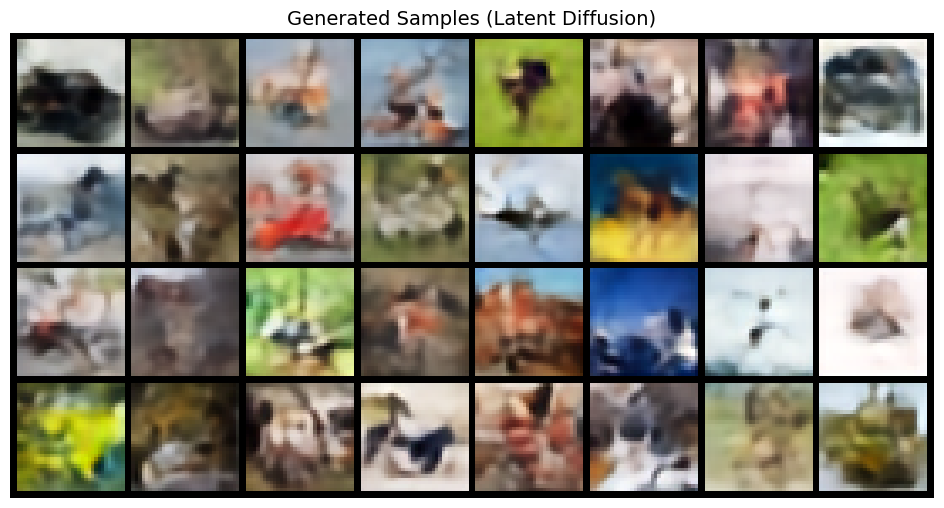

In [14]:
from text_to_image.sampling import sample_latent

# Generate samples
latent_dit.eval()
vae.eval()

print("Generating samples via latent diffusion...")
print("  1. Sample noise in latent space (4×8×8)")
print("  2. Integrate ODE from t=1 to t=0")
print("  3. Decode to pixel space (3×32×32)")
print()

with torch.no_grad():
    generated = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=32,
        latent_shape=(4, 8, 8),
        num_steps=50,
        device=device,
    )

show_images(generated, nrow=8, title="Generated Samples (Latent Diffusion)")

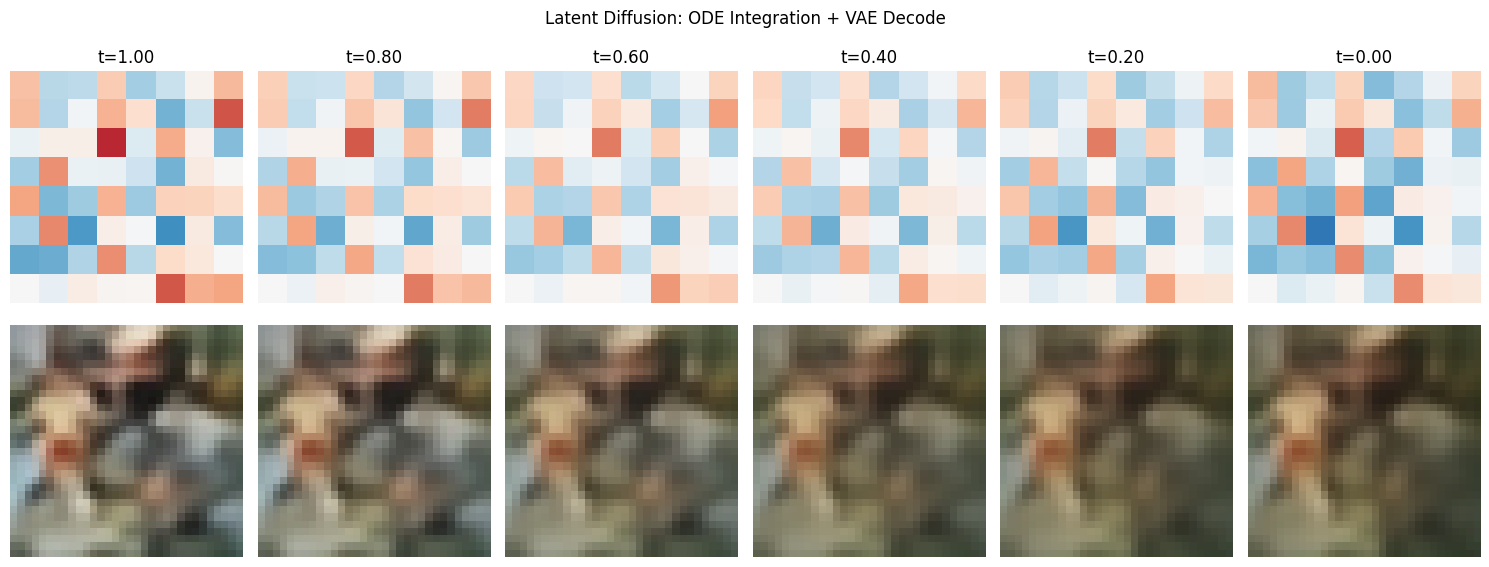


Observe how:
  - t=1: Pure noise in latent space → noisy decoded image
  - t→0: Structure emerges in latent → coherent image forms


In [15]:
# Visualize the generation process in latent space
with torch.no_grad():
    generated, trajectory = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=4,
        latent_shape=(4, 8, 8),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

# Show evolution of one sample
steps_to_show = [0, 10, 20, 30, 40, 50]
fig, axes = plt.subplots(2, len(steps_to_show), figsize=(15, 6))

for col, step_idx in enumerate(steps_to_show):
    t_val = 1.0 - step_idx / 50
    
    # Latent (show first channel)
    latent = trajectory[step_idx][0, 0].cpu().numpy()
    axes[0, col].imshow(latent, cmap='RdBu', vmin=-3, vmax=3)
    axes[0, col].set_title(f't={t_val:.2f}')
    axes[0, col].axis('off')
    
    # Decoded image
    with torch.no_grad():
        decoded = vae.decode(trajectory[step_idx][:1])
    img = (decoded[0].cpu().permute(1, 2, 0) + 1) / 2
    axes[1, col].imshow(img.clamp(0, 1).numpy())
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('Latent\n(8×8)', fontsize=10)
axes[1, 0].set_ylabel('Decoded\n(32×32)', fontsize=10)

plt.suptitle('Latent Diffusion: ODE Integration + VAE Decode', fontsize=12)
plt.tight_layout()
plt.show()

print("\nObserve how:")
print("  - t=1: Pure noise in latent space → noisy decoded image")
print("  - t→0: Structure emerges in latent → coherent image forms")

## 8. Class-Conditional Latent Diffusion

We can add class conditioning just like in Phase 3, but in latent space.

The architecture is identical to `ConditionalDiT`, just operating on latent shapes.

In [16]:
from text_to_image.dit import ConditionalDiT

# Create class-conditional DiT for latent space
cond_latent_dit = ConditionalDiT(
    num_classes=10,       # CIFAR-10 classes
    img_size=8,           # Latent spatial size
    patch_size=2,         # 2×2 patches
    in_channels=4,        # Latent channels
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=4.0,
).to(device)

print(f"Conditional Latent DiT parameters: {sum(p.numel() for p in cond_latent_dit.parameters()):,}")

Conditional Latent DiT parameters: 12,363,024


In [17]:
from text_to_image.train import LatentConditionalTrainer

# Train conditional latent diffusion
cond_latent_trainer = LatentConditionalTrainer(
    model=cond_latent_dit,
    vae=vae,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    label_drop_prob=0.1,  # 10% dropout for CFG
    num_classes=10,
    device=device,
)

COND_EPOCHS = 30
print(f"Training Conditional Latent Diffusion for {COND_EPOCHS} epochs...")
print()

cond_losses = cond_latent_trainer.train(num_epochs=COND_EPOCHS)

Training Conditional Latent Diffusion for 30 epochs...

Training Latent Conditional Diffusion on cuda
DiT parameters: 12,363,024
CFG label dropout: 10%


Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.66it/s, loss=1.4983]


Epoch 1: avg_loss = 1.6230


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.4266]


Epoch 2: avg_loss = 1.4490


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.86it/s, loss=1.3999]


Epoch 3: avg_loss = 1.4291


Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.97it/s, loss=1.4288]


Epoch 4: avg_loss = 1.4185


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.87it/s, loss=1.4060]


Epoch 5: avg_loss = 1.4084


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.98it/s, loss=1.3812]


Epoch 6: avg_loss = 1.4021


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.87it/s, loss=1.4130]


Epoch 7: avg_loss = 1.3969


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.99it/s, loss=1.4177]


Epoch 8: avg_loss = 1.3940


Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.4220]


Epoch 9: avg_loss = 1.3869


Epoch 10/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.87it/s, loss=1.4346]


Epoch 10: avg_loss = 1.3835


Epoch 11/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.80it/s, loss=1.3331]


Epoch 11: avg_loss = 1.3805


Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.88it/s, loss=1.4187]


Epoch 12: avg_loss = 1.3754


Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.89it/s, loss=1.4016]


Epoch 13: avg_loss = 1.3734


Epoch 14/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.3755]


Epoch 14: avg_loss = 1.3727


Epoch 15/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.86it/s, loss=1.3842]


Epoch 15: avg_loss = 1.3709


Epoch 16/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.3596]


Epoch 16: avg_loss = 1.3665


Epoch 17/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.82it/s, loss=1.3345]


Epoch 17: avg_loss = 1.3616


Epoch 18/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.68it/s, loss=1.3435]


Epoch 18: avg_loss = 1.3618


Epoch 19/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.93it/s, loss=1.3618]


Epoch 19: avg_loss = 1.3570


Epoch 20/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.88it/s, loss=1.3459]


Epoch 20: avg_loss = 1.3584


Epoch 21/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.80it/s, loss=1.3331]


Epoch 21: avg_loss = 1.3543


Epoch 22/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.80it/s, loss=1.3598]


Epoch 22: avg_loss = 1.3533


Epoch 23/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.83it/s, loss=1.3784]


Epoch 23: avg_loss = 1.3527


Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.83it/s, loss=1.2663]


Epoch 24: avg_loss = 1.3495


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.84it/s, loss=1.3612]


Epoch 25: avg_loss = 1.3495


Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.91it/s, loss=1.3485]


Epoch 26: avg_loss = 1.3482


Epoch 27/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.79it/s, loss=1.3602]


Epoch 27: avg_loss = 1.3462


Epoch 28/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.86it/s, loss=1.3881]


Epoch 28: avg_loss = 1.3436


Epoch 29/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.84it/s, loss=1.3172]


Epoch 29: avg_loss = 1.3411


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 38.75it/s, loss=1.3452]

Epoch 30: avg_loss = 1.3411


Generating one sample per class with CFG...


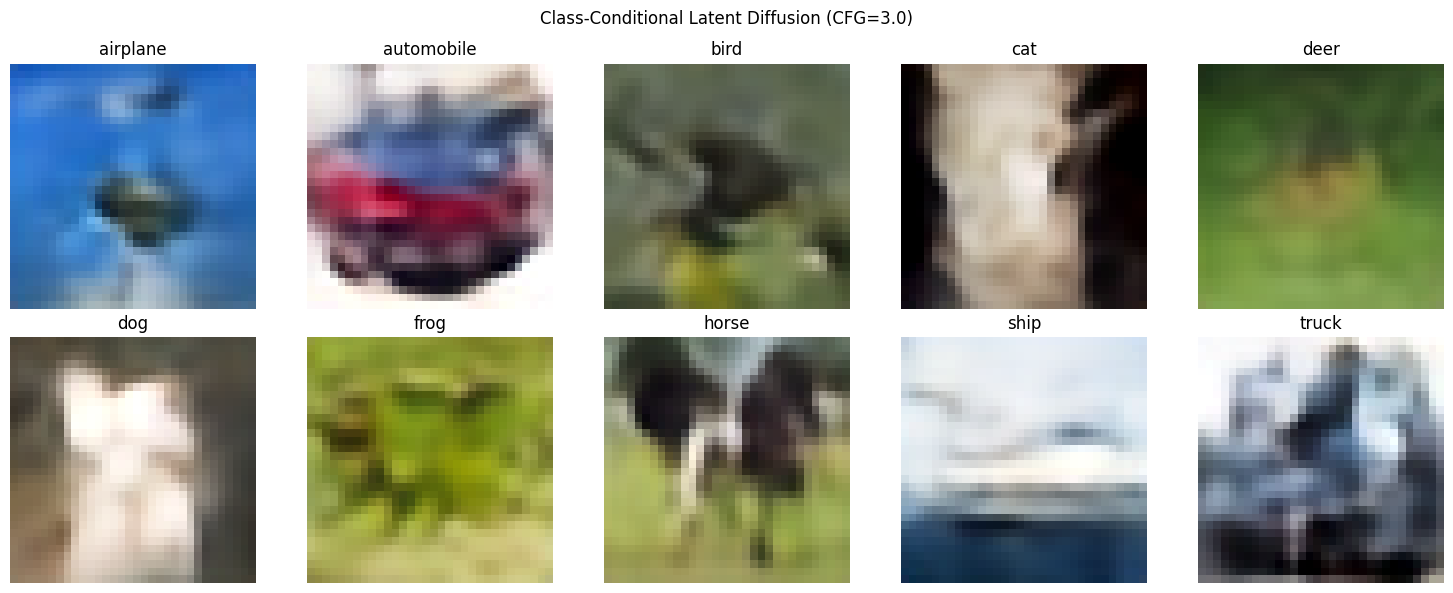

In [18]:
from text_to_image.sampling import sample_latent_conditional

# CIFAR-10 class names
CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

cond_latent_dit.eval()

# Generate one sample per class
print("Generating one sample per class with CFG...")

with torch.no_grad():
    class_samples = sample_latent_conditional(
        model=cond_latent_dit,
        vae=vae,
        class_labels=list(range(10)),
        latent_shape=(4, 8, 8),
        num_steps=50,
        cfg_scale=3.0,
        device=device,
        num_classes=10,
    )

# Display with class labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, class_name) in enumerate(zip(axes.flat, CIFAR10_CLASSES)):
    img = (class_samples[i].cpu().permute(1, 2, 0) + 1) / 2
    ax.imshow(img.clamp(0, 1).numpy())
    ax.set_title(class_name)
    ax.axis('off')

plt.suptitle('Class-Conditional Latent Diffusion (CFG=3.0)', fontsize=12)
plt.tight_layout()
plt.show()

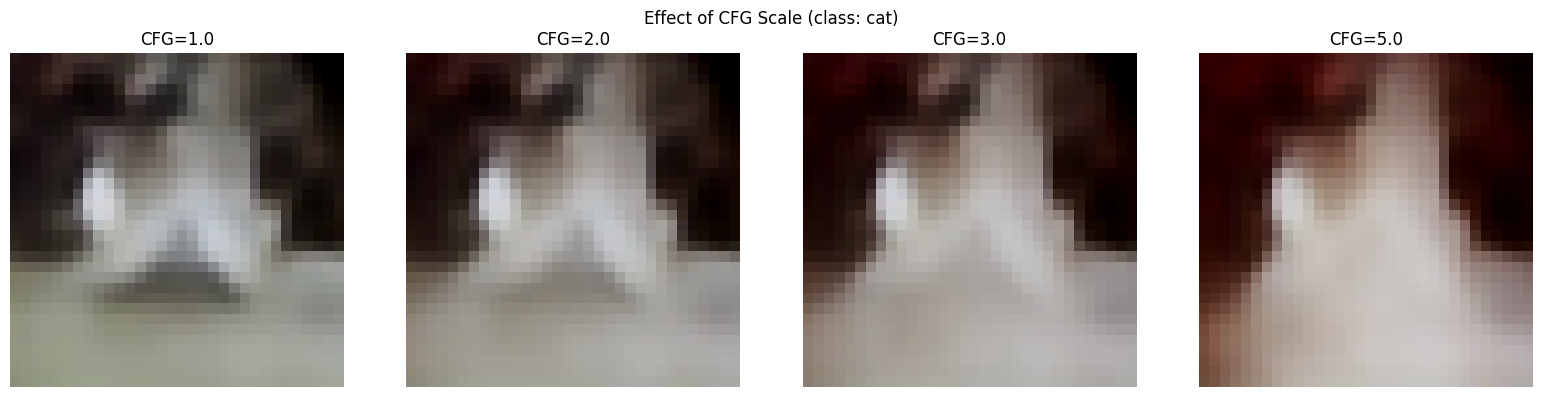

Higher CFG → stronger class adherence but potentially less diversity


In [19]:
# Compare CFG scales
cfg_scales = [1.0, 2.0, 3.0, 5.0]
target_class = 3  # cat

fig, axes = plt.subplots(1, len(cfg_scales), figsize=(16, 4))

for ax, scale in zip(axes, cfg_scales):
    torch.manual_seed(42)  # Same seed for comparison
    
    with torch.no_grad():
        sample = sample_latent_conditional(
            model=cond_latent_dit,
            vae=vae,
            class_labels=[target_class],
            latent_shape=(4, 8, 8),
            num_steps=50,
            cfg_scale=scale,
            device=device,
        )
    
    img = (sample[0].cpu().permute(1, 2, 0) + 1) / 2
    ax.imshow(img.clamp(0, 1).numpy())
    ax.set_title(f'CFG={scale}')
    ax.axis('off')

plt.suptitle(f'Effect of CFG Scale (class: {CIFAR10_CLASSES[target_class]})', fontsize=12)
plt.tight_layout()
plt.show()

print("Higher CFG → stronger class adherence but potentially less diversity")

## 9. Computational Comparison

Let's compare the computational requirements of pixel-space vs latent-space diffusion.

In [20]:
import time

# Time comparison
num_samples = 16
num_steps = 50

# Latent space timing
torch.cuda.synchronize() if torch.cuda.is_available() else None
start = time.time()

with torch.no_grad():
    _ = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=num_samples,
        latent_shape=(4, 8, 8),
        num_steps=num_steps,
        device=device,
    )

torch.cuda.synchronize() if torch.cuda.is_available() else None
latent_time = time.time() - start

print(f"Latent Diffusion ({num_samples} samples, {num_steps} steps):")
print(f"  Time: {latent_time:.2f}s")
print(f"  Per image: {latent_time/num_samples*1000:.1f}ms")
print()
print("Latent space details:")
print(f"  Latent shape: (4, 8, 8) = 256 values")
print(f"  Patches: 4×4 = 16 tokens")
print(f"  Attention per step: 16×16 = 256 pairs")

Latent Diffusion (16 samples, 50 steps):
  Time: 0.12s
  Per image: 7.5ms

Latent space details:
  Latent shape: (4, 8, 8) = 256 values
  Patches: 4×4 = 16 tokens
  Attention per step: 16×16 = 256 pairs


## Summary: The Complete Latent Diffusion Pipeline

### Architecture

```
TRAINING:
                                                      Flow Matching Loss
                                                             ↑
Image x ───────> [VAE Encoder] ───> z_0 ───> z_t ───> [DiT] ───> v_pred
                   (frozen)          ↑         ↑
                                     |    noise z_1, time t
                                     |
                              scale_factor

INFERENCE:
Noise z_1 ───> [DiT + ODE] ───> z_0 ───> [VAE Decoder] ───> Image x
```

### Key Equations

| Component | Equation | Purpose |
|-----------|----------|----------|
| VAE Encode | $z = \mu + \sigma \epsilon$ | Compress to latent |
| VAE Decode | $\hat{x} = D(z)$ | Reconstruct image |
| VAE Loss | $\mathcal{L} = \|x-\hat{x}\|^2 + \beta D_{KL}$ | Train VAE |
| Latent Interpolation | $z_t = (1-t)z_0 + tz_1$ | Flow path |
| Latent Velocity | $v = z_1 - z_0$ | Target |
| Training Loss | $\mathcal{L} = \|v_\theta(z_t, t) - v\|^2$ | Train DiT |
| Generation | $z_0 = z_1 - \int_1^0 v_\theta(z_t, t) dt$ | ODE solve |

### Compression Ratios

| Resolution | Pixel Dims | Latent Dims | Compression |
|------------|------------|-------------|-------------|
| 32×32×3 | 3,072 | 8×8×4 = 256 | 12× |
| 64×64×3 | 12,288 | 8×8×4 = 256 | 48× |
| 256×256×3 | 196,608 | 32×32×4 = 4,096 | 48× |
| 512×512×3 | 786,432 | 64×64×4 = 16,384 | 48× |

### Advantages of Latent Diffusion

1. **Efficiency**: 48× fewer dimensions means faster training and inference
2. **Scalability**: Can handle high-resolution images that would be infeasible in pixel space
3. **Quality**: VAE provides perceptually meaningful compression
4. **Flexibility**: Same DiT architecture works across resolutions

### This Is How Stable Diffusion Works!

The techniques in this notebook are the foundation of Stable Diffusion:
- VAE compresses 512×512 images to 64×64 latents
- U-Net (or DiT) does flow matching in latent space
- CLIP text encoder provides conditioning
- CFG provides strong text adherence

Congratulations! You now understand the complete text-to-image pipeline.

In [21]:
# Save trained models
vae_trainer.save_checkpoint("phase5_vae.pt")
latent_trainer.save_checkpoint("phase5_latent_dit.pt")
cond_latent_trainer.save_checkpoint("phase5_cond_latent_dit.pt")

print("Models saved!")
print("  - phase5_vae.pt")
print("  - phase5_latent_dit.pt")
print("  - phase5_cond_latent_dit.pt")

Models saved!
  - phase5_vae.pt
  - phase5_latent_dit.pt
  - phase5_cond_latent_dit.pt
